In [1]:
!pip install pyfluidsynth

  Preparing metadata (setup.py) ... done
  Created wheel for pyfluidsynth: filename=pyFluidSynth-1.3.3-py3-none-any.whl size=19185 sha256=b686b74cc39d1d5c982c89d36bb68d2a538859537d5c192244acc387af5b5e75
  Stored in directory: /root/.cache/pip/wheels/e6/9c/2b/b4b194cbb100d6f20136a22b2f76cd329b1a21139ed26c9775
Successfully built pyfluidsynth


In [2]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [4]:
! pip install --upgrade pyfluidsynth

In [5]:
! pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 58.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.5 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=0f0c09e1b0435e1be1238e33183bd2fcb9de42a94d89efd9afd0d8046be2d7ce
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


In [6]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional
import librosa

In [7]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [8]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59243107/59243107 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [9]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


In [10]:
sample_file = filenames[1]
print(sample_file)


data/maestro-v2.0.0/2018/MIDI-Unprocessed_Recital4_MID--AUDIO_04_R1_2018_wav--4.midi


In [11]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [12]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [13]:
display_audio(pm)

In [14]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [15]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=62, note_name=D4, duration=0.7344
1: pitch=70, note_name=A#4, duration=1.0599
2: pitch=62, note_name=D4, duration=0.2604
3: pitch=70, note_name=A#4, duration=0.1315
4: pitch=55, note_name=G3, duration=2.2956
5: pitch=62, note_name=D4, duration=0.0742
6: pitch=55, note_name=G3, duration=0.0846
7: pitch=62, note_name=D4, duration=0.0638
8: pitch=70, note_name=A#4, duration=0.0846
9: pitch=62, note_name=D4, duration=0.0378


In [16]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [17]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

pitch     start       end      step  duration
0     55  0.983073  3.278646  0.000000  2.295573
1     79  1.242188  4.494792  0.259115  3.252604
2     67  1.247396  4.213542  0.005208  2.966146
3     62  1.250000  1.984375  0.002604  0.734375
4     74  1.250000  4.328125  0.000000  3.078125

In [18]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['G3', 'G5', 'G4', 'D4', 'D5', 'A#4', 'D4', 'A#4', 'D4', 'G3'],
      dtype='<U3')

In [19]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

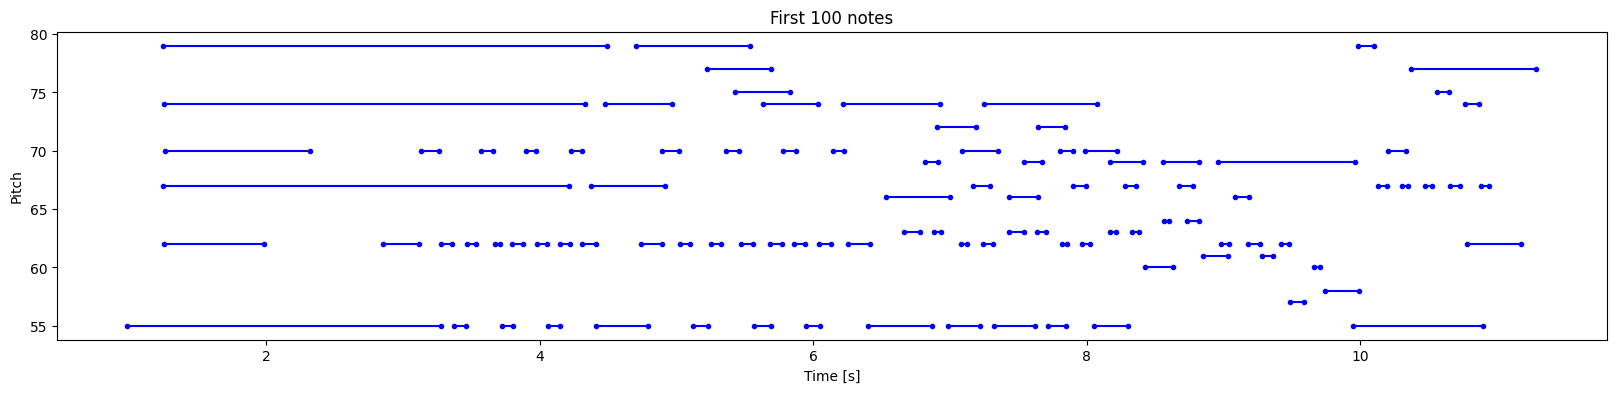

In [20]:
plot_piano_roll(raw_notes, count=100)

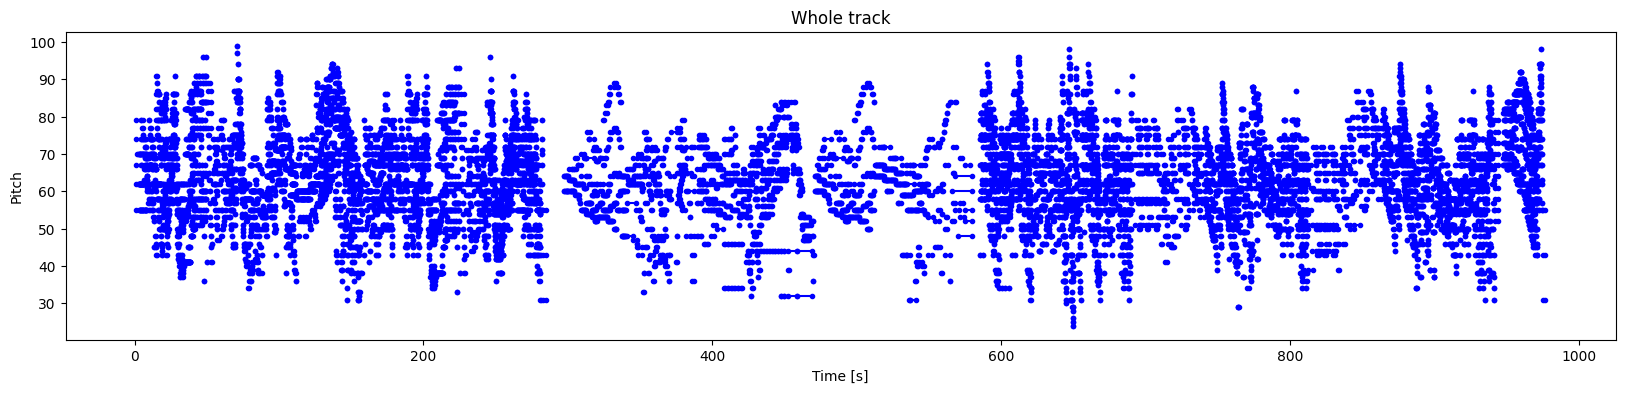

In [21]:
plot_piano_roll(raw_notes)

In [22]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

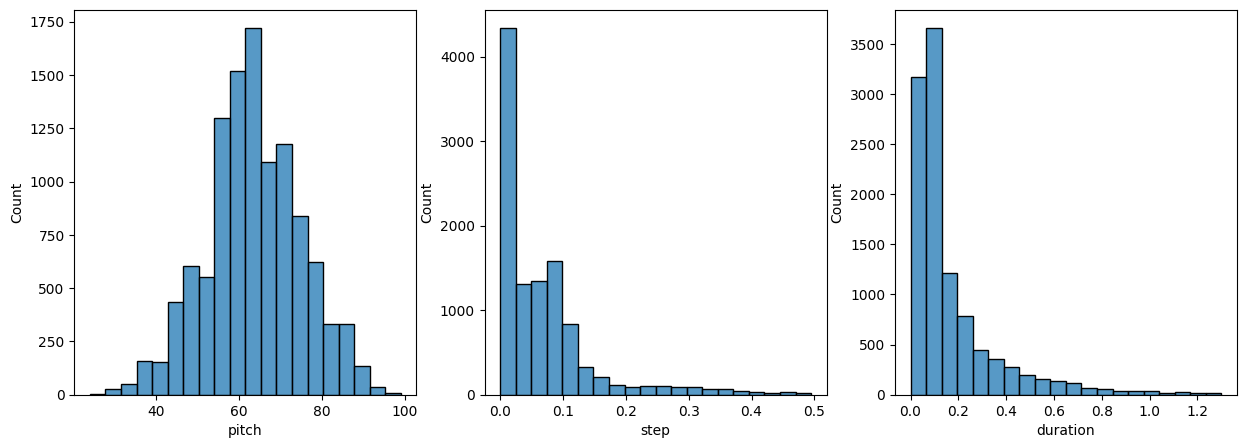

In [23]:
plot_distributions(raw_notes)

In [24]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [25]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [26]:
display_audio(example_pm)

In [27]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [28]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 43581


In [29]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [30]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [31]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [32]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [33]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.53125    0.         1.1328125 ]
 [0.5546875  0.31901042 0.28255208]
 [0.40625    0.21484375 0.20963542]
 [0.4609375  0.16015625 0.14322917]
 [0.5546875  0.14192708 0.72916667]
 [0.515625   0.15625    0.37760417]
 [0.4921875  0.11848958 0.11979167]
 [0.3984375  0.1171875  0.05859375]
 [0.5        0.14322917 0.51953125]
 [0.53125    0.125      0.18359375]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=66.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.19401041666666696>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.42317708333333304>}


In [34]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [35]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [36]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [37]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 25, 3)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 128)            │         67,584 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration (Dense)          │ (None, 1)              │            129 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pitch (Dense)             │ (None, 128)            │         16,512 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ step (Dense)              │ (None, 1)              │            129 │ lstm[0][0]             │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
losses = model.evaluate(train_ds, return_dict=True)
losses

680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 5.1331


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


{'loss': 5.147683620452881}

In [39]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [40]:
model.evaluate(train_ds, return_dict=True)

680/680 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5216


{'loss': 0.5428202152252197}

In [41]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [42]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.4057
Epoch 2/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.3823
Epoch 3/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3761
Epoch 4/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.3739
Epoch 5/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3684
Epoch 6/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3660
Epoch 7/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3644
Epoch 8/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3611
Epoch 9/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3606
Epoch 10/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3588
Epoch 11/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3537
Epoch 12/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.3514
Epoch 13/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3507
Epoch 14/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3453
Epoch 15/50
680/680 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - lo

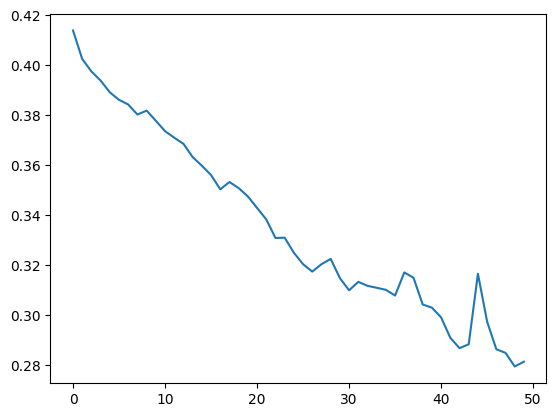

In [43]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [44]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [45]:
import random
# Set a random temperature value between least (0.1) and max (5.0)
temperature = random.uniform(0.1, 5.0)  # Adjust the min and max as needed
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

In [46]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [47]:
from google.colab import files
files.download(out_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

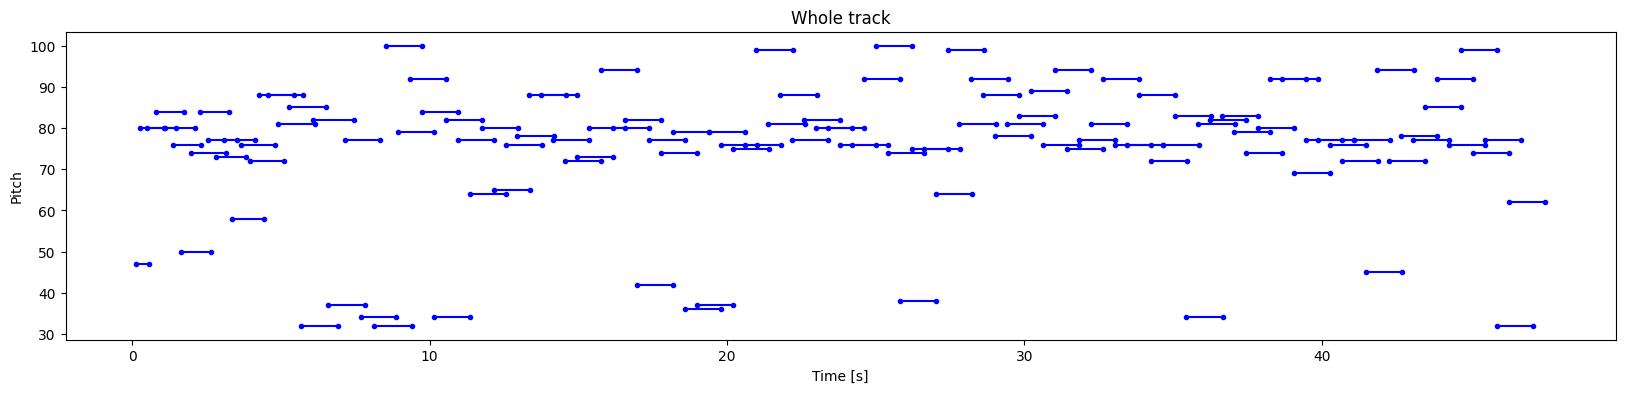

In [48]:
plot_piano_roll(generated_notes)

In [49]:
def set_genre_parameters(genre):
    """
    Sets parameters like tempo, key, and instrument based on the chosen genre.

    Parameters:
        genre (str): The music genre to set parameters for.
                     Options: "classical", "jazz", "rock", "electronic", "pop".

    Returns:
        dict: A dictionary of genre-specific parameters.
    """
    genre_settings = {
        "classical": {
            "tempo": 60,
            "key": "C",
            "instrument": "Acoustic Grand Piano",
            "rhythm_pattern": "standard"
        },
        "jazz": {
            "tempo": 120,
            "key": "Bb",
            "instrument": "Electric Piano 1",
            "rhythm_pattern": "swing"
        },
        "rock": {
            "tempo": 140,
            "key": "E",
            "instrument": "Electric Guitar (clean)",
            "rhythm_pattern": "backbeat"
        },
        "electronic": {
            "tempo": 128,
            "key": "Am",
            "instrument": "Synth Bass 1",
            "rhythm_pattern": "four_on_the_floor"
        },
        "pop": {
            "tempo": 100,
            "key": "G",
            "instrument": "Acoustic Guitar (steel)",
            "rhythm_pattern": "standard"
        }
    }

    return genre_settings.get(genre.lower(), genre_settings["pop"])

def apply_genre_settings(notes, genre_params):
    """
    Applies genre-specific settings to the notes.

    Parameters:
        notes (pd.DataFrame): A DataFrame containing notes with columns like pitch, start, end.
        genre_params (dict): Dictionary of genre-specific parameters.

    Returns:
        pd.DataFrame: Modified notes DataFrame with genre-applied settings.
    """
    # Set tempo by adjusting note start and end times based on the tempo multiplier
    tempo_multiplier = genre_params["tempo"] / 120  # Assuming 120 BPM as a baseline
    notes["start"] *= tempo_multiplier
    notes["end"] *= tempo_multiplier

    # Apply a simple rhythm pattern for demonstration
    if genre_params["rhythm_pattern"] == "swing":
        notes["start"] += (notes.index % 2) * 0.05  # Adds slight swing feel

    return notes

def generate_music(genre="pop"):
    """
    Generates music based on the chosen genre.

    Parameters:
        genre (str): The genre to generate music in.

    Returns:
        pretty_midi.PrettyMIDI: The generated music with genre settings applied.
    """
    # Set genre-specific parameters
    genre_params = set_genre_parameters(genre)

    # Load or generate a note sequence, apply genre settings
    notes = midi_to_notes(sample_file)  # Assuming `midi_to_notes` is in the original script
    notes = apply_genre_settings(notes, genre_params)

    # Convert notes to MIDI with selected instrument
    midi_file = f"{genre}_example.midi"
    example_pm = notes_to_midi(notes, midi_file, genre_params["instrument"])

    return display_audio(example_pm)


In [50]:
generate_music(genre="pop")

In [ ]:
generate_music(genre="rock")

In [ ]:
generate_music(genre="classical")

In [51]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import soundfile as sf
from tensorflow.keras.models import load_model

In [52]:
import librosa

def extract_sample_features(input_file: str) -> dict:
    """
    Extracts features from a short music file to guide music generation.

    Parameters:
        input_file (str): Path to the input music file.

    Returns:
        dict: A dictionary containing extracted features like tempo, key, and pitch classes.
    """
    # Load audio file
    y, sr = librosa.load(input_file, duration=5)  # Load up to 5 seconds for feature extraction

    # Extract tempo and beat
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

    # Extract key (chroma feature gives an estimate of the pitch class)
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
    key = np.argmax(chroma.sum(axis=1))

    # Extract average pitch as an indication of overall melody
    pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr)
    avg_pitch = np.nanmean(pitches)

    return {
        "tempo": tempo,
        "key": key,
        "avg_pitch": avg_pitch
    }

def generate_extended_music(input_file: str, output_duration: int = 30):
    """
    Generates extended music based on a short input file's characteristics.

    Parameters:
        input_file (str): Path to the input file (3-5 seconds of music).
        output_duration (int): The desired output duration in seconds.

    Returns:
        pretty_midi.PrettyMIDI: The generated music with extended duration.
    """
    # Extract features from the input file
    sample_features = extract_sample_features(input_file)

    # Set genre-like parameters based on sample features
    tempo_multiplier = sample_features["tempo"] / 120  # Normalize with a baseline
    key_pitch = sample_features["avg_pitch"]  # Use average pitch as an influence

    # Prepare notes and adjust tempo
    input_notes = midi_to_notes(sample_file)
    input_notes["start"] *= tempo_multiplier
    input_notes["end"] *= tempo_multiplier

    # Extend input notes to reach the desired duration
    num_predictions = int((output_duration - input_notes['end'].iloc[-1]) / tempo_multiplier)

    generated_notes = []
    prev_start = input_notes['start'].iloc[-1]
    for _ in range(num_predictions):
        pitch, step, duration = predict_next_note(input_notes, model, temperature=1.0)
        start = prev_start + step
        end = start + duration
        generated_notes.append((pitch, step, duration, start, end))
        prev_start = start

    # Convert to DataFrame for further processing
    generated_notes = pd.DataFrame(generated_notes, columns=(*key_order, 'start', 'end'))

    # Apply additional modifications, such as key pitch if desired
    generated_notes['pitch'] = generated_notes['pitch'].fillna(0)  # Replace NaN with 0
    generated_notes['pitch'] += int(key_pitch - generated_notes['pitch'].mean())

    # Convert generated notes to MIDI and play it
    output_file = 'extended_output.midi'
    out_pm = notes_to_midi(generated_notes, output_file, "Acoustic Grand Piano")
    return display_audio(out_pm)

# Example usage with a 3-5 second input file path
generate_extended_music(input_file="/content/output.mid")


<ipython-input-52-066fe4cb68c5>:14: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(input_file, duration=5)  # Load up to 5 seconds for feature extraction
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


NoBackendError: 

In [61]:
!pip install pretty_midi

import pretty_midi
import librosa
import IPython.display as ipd

def generate_extended_music(input_file: str, output_duration: int = 30):
    """
    Generates extended music based on a short input file's characteristics.

    Parameters:
        input_file (str): Path to the input file (3-5 seconds of music).
        output_duration (int): The desired output duration in seconds.
    """
    # 1. Convert MIDI to WAV (using pretty_midi)
    midi_data = pretty_midi.PrettyMIDI(input_file)
    audio_data = midi_data.fluidsynth() # Synthesize audio from MIDI

    # Save as temporary WAV file
    # You could consider a more robust temporary file solution
    # but this will help us demonstrate the flow.
    with open("/content/temp.wav", "wb") as f:
        f.write(audio_data)

    # 2. Load the audio using librosa
    y, sr = librosa.load("/content/temp.wav", duration=5)

    # ... (rest of your feature extraction and music generation logic) ...

# Example usage
generate_extended_music(input_file="/content/pop_example.midi")

<ipython-input-61-3c91a033c16c>:26: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load("/content/temp.wav", duration=5)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [63]:
!pip install soundfile

In [65]:
!pip install pretty_midi librosa pydub

import pretty_midi
import librosa
import IPython.display as ipd
from pydub import AudioSegment
import numpy as np
import soundfile as sf
def generate_extended_music(input_file: str, output_duration: int = 30, output_file: str = "extended_output.mp3"):
    """
    Generates extended music based on a short input file's characteristics and saves it as an MP3.

    Parameters:
        input_file (str): Path to the input MIDI file (3-5 seconds of music).
        output_duration (int): The desired output duration in seconds.
        output_file (str): Path to save the output MP3 file.
    """
    # 1. Convert MIDI to WAV (using pretty_midi)
    midi_data = pretty_midi.PrettyMIDI(input_file)
    audio_data = midi_data.fluidsynth()  # Synthesize audio from MIDI

    # Convert numpy array audio data to a WAV file using librosa
    temp_wav_file = "temp_output.wav"
    #librosa.output.write_wav(temp_wav_file, audio_data, sr=22050)  # Temporary WAV save
    sf.write(temp_wav_file, audio_data, 22050)  # Temporary WAV save

    # 2. Load the audio using librosa
    y, sr = librosa.load(temp_wav_file, duration=5)

    # 3. Generate extended music here
    # Placeholder for feature extraction and music generation
    # Extended audio data should be created here, for now we repeat the audio

    extended_audio = np.tile(y, int(np.ceil(output_duration / 5)))  # Repeat to match output duration
    extended_audio = extended_audio[:int(output_duration * sr)]  # Trim to exact output_duration

    # Save the extended WAV as a temporary file
    extended_wav_file = "extended_temp_output.wav"
    #librosa.output.write_wav(extended_wav_file, extended_audio, sr=sr)
    sf.write(extended_wav_file, extended_audio, sr)

    # 4. Convert the WAV file to MP3
    # Load WAV using pydub and export as MP3
    sound = AudioSegment.from_wav(extended_wav_file)
    sound.export(output_file, format="mp3")

    print(f"Extended music saved as {output_file}")
    return ipd.Audio(output_file)

# Example usage
generate_extended_music(input_file="/content/pop_example.midi")


Extended music saved as extended_output.mp3


In [67]:
model.save('/content/musicmodel.h5')